In [27]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

# Read in input files

In [2]:
#Ecoli information
ecoli_df = pd.read_csv('../Data/ecoli_info/current_ecoli_master_table.tsv', sep='\t')

In [3]:
ecoli_df

,locus_tag,gene,start_loc,stop_loc,strand,cds_seq,us_seq,cds_len,well_behaved,GC_percent_cds,roc_semppr_mean,iCUB,CAI,tAI,stAIcalc,aSD_binding,sec_struct,sec_struct_bound,Start_accessibility
0,b0001,thrL,189,255,+,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,CAGATAAAAATTACAGAGTACACAACATCC,66,True,0.515152,1.244106,32.046035,0.617266,0.262286,0.258417,-2.45,NaN,NaN,NaN
1,b0002,thrA,336,2799,+,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,TTTTCGACCAAAGGTAACGAGGTAACAACC,2463,True,0.530654,1.034078,55.949262,0.353246,0.230564,0.216862,-5.42,-21.31,-12.81,-8.50
2,b0003,thrB,2800,3733,+,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,GTACCCTCTCATGGAAGTTAGGAGTCTGAC,933,True,0.562701,0.994168,56.062386,0.357812,0.216292,0.210420,-6.51,-21.87,-14.05,-7.82
3,b0004,thrC,3733,5020,+,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,ACGGCGGGCGCACGAGTACTGGAAAACTAA,1287,True,0.528361,1.176750,53.052776,0.394675,0.231407,0.209784,-3.40,-24.44,-20.71,-3.73
4,b0005,yaaX,5233,5530,+,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,CATAACGGGCAATGATAAAAGGAGTAACCT,297,True,0.538721,0.837528,50.705530,0.374371,0.197715,0.208944,-6.51,-17.15,-7.38,-9.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4350,b4399,creC,4636695,4638120,+,ATGCGTATCGGCATGCGGTTGTTGCTGGGCTATTTTTTACTGGTGG...,CGGCATGGGATATAGCCTGAGGGGCCTGTA,1425,True,0.538947,0.829794,55.967103,0.293537,0.212672,0.206721,-6.09,-31.71,-18.33,-13.38
4351,b4400,creD,4638177,4639530,+,ATGTTGAAATCCCCCCTGTTCTGGAAAATGACTAGCCTGTTTGGTG...,TATCCTGCTGCCATTGCAAAGGAGAAGACT,1353,True,0.495935,0.739848,54.634345,0.288635,0.210078,0.199677,-7.00,-16.18,-10.40,-5.78
4352,b4401,arcA,4639589,4640306,-,ATGCAGACCCCGCACATTCTTATCGTTGAAGACGAGTTGGTAACAC...,TCGATTTAGTTGGCAATTTAGGTAGCAAAC,717,True,0.510460,1.676448,48.981781,0.530773,0.275348,0.239921,-2.60,-16.36,-9.19,-7.17
4353,b4402,yjjY,4640401,4640542,+,ATGACTAAAGTACGTAATTGCGTTCTTGATGCACTTTCCATCAACG...,CATGCTGCAAATTAACATGATCGGCGTAAC,141,True,0.425532,0.802032,47.451431,0.314394,0.219204,0.230201,-1.76,-14.24,-7.14,-7.10


In [4]:
df = pd.ExcelFile(r'../Data/raw_data/41467_2019_13483_MOESM4_ESM.xlsx')

In [5]:
expression_df = df.parse('Expression Data', index_col='log-TPM')
metadata_df = df.parse('Metadata')

# Remove all Sample IDs that are irrelevant

In [6]:
#Remove samples that contain no growth rate information
metadata_df = metadata_df.dropna(subset=['Growth Rate (1/hr)'])
metadata_df = metadata_df[metadata_df['Growth Rate (1/hr)'] != 0]

In [7]:
#Remove all Sample IDs where the alignment is less than 80%
metadata_df = metadata_df[metadata_df['Alignment'] > 80]

In [8]:
#Remove all columns where no growth rate information was found
expression_df = expression_df[metadata_df['Sample ID']]
assert list(metadata_df['Sample ID']) == list(expression_df.columns)

***Average across replicates and drop them***

In [9]:
cols = []
unique_cols = []
expression_clean_df = copy.deepcopy(expression_df)

#Rename columns in dataframe
for column in expression_df.columns:
    cols.append(column[:-3])
    #Get names of unique columns
    if column[:-3] not in unique_cols:
        unique_cols.append(column[:-3])

expression_clean_df.columns = cols

#New dataframe with averaged replicates and no duplicates
expression_clean_df = expression_clean_df[unique_cols].groupby(level=0, axis=1).mean()

In [10]:
#Average growth rate in metadata df

cond = []
unique_cond = []
metadata_clean_df = copy.deepcopy(metadata_df)

for condition in metadata_df['Sample ID']:
    cond.append(condition[:-3])
    if condition[:-3] not in unique_cond:
        unique_cond.append(condition[:-3])
        
metadata_clean_df['Sample ID'] = cond

#New dataframe with averaged replicates and no duplicates
metadata_clean_df = metadata_clean_df.groupby('Sample ID').mean()

In [11]:
#Make sure columns are the same in expression data as metadata
print(metadata_clean_df.shape)
print(expression_clean_df.shape)

(105, 6)
(3923, 105)


In [12]:
#Remove genes from ecoli_df if not tagged in expression dataset
ecoli_clean_df = copy.deepcopy(ecoli_df)

for locus in range(len(ecoli_df)):
    if ecoli_df['locus_tag'][locus] not in expression_clean_df.index.tolist():
        ecoli_clean_df = ecoli_clean_df.drop(locus)

expression_final_df = copy.deepcopy(expression_clean_df)

for locus in range(len(expression_clean_df)):
    if expression_clean_df.index[locus] not in ecoli_clean_df['locus_tag'].tolist():
        expression_final_df = expression_final_df.drop(expression_clean_df.index[locus])

In [13]:
print(ecoli_clean_df.shape)
print(expression_final_df.shape)

(3859, 19)
(3859, 105)


# Correlation between codon bias metrics

In [14]:
metric_df = ecoli_clean_df[['iCUB', 'roc_semppr_mean', 'CAI', 'tAI', 'stAIcalc', 'aSD_binding', 'sec_struct', 'sec_struct_bound', 'Start_accessibility']]
metric_df

,iCUB,roc_semppr_mean,CAI,tAI,stAIcalc
1,55.949262,1.034078,0.353246,0.230564,0.216862
2,56.062386,0.994168,0.357812,0.216292,0.210420
3,53.052776,1.176750,0.394675,0.231407,0.209784
4,50.705530,0.837528,0.374371,0.197715,0.208944
5,53.158862,1.032499,0.353849,0.225856,0.213151
...,...,...,...,...,...
4349,54.346407,0.752851,0.275049,0.212304,0.195169
4350,55.967103,0.829794,0.293537,0.212672,0.206721
4351,54.634345,0.739848,0.288635,0.210078,0.199677
4352,48.981781,1.676448,0.530773,0.275348,0.239921


In [15]:
metric_corr = metric_df.corr(method='spearman')
metric_corr

,iCUB,roc_semppr_mean,CAI,tAI,stAIcalc
iCUB,1.000000,-0.515658,-0.581081,-0.538805,-0.486559
roc_semppr_mean,-0.515658,1.000000,0.939023,0.837262,0.546885
CAI,-0.581081,0.939023,1.000000,0.843535,0.695474
tAI,-0.538805,0.837262,0.843535,1.000000,0.740101
stAIcalc,-0.486559,0.546885,0.695474,0.740101,1.000000


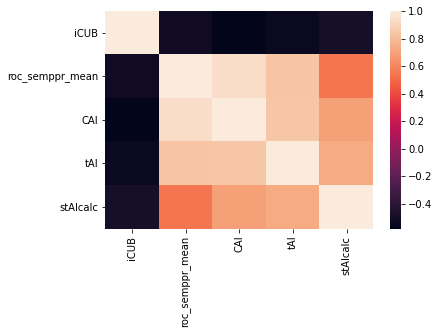

In [16]:
#Visualize correlation matrix
sns.heatmap(metric_corr)
plt.show()

# Correlate metrics with gene expression

In [19]:
#Average expression data
avg_expression_list = []

for g in expression_final_df.values:
    avg_expression_list.append(np.mean(g))

In [20]:
#Median expression data
med_expression_list = []

for g in expression_final_df.values:
    med_expression_list.append(np.median(g))

In [22]:
#Max expression data
max_expression_list = []

for g in expression_final_df.values:
    max_expression_list.append(max(g))

In [23]:
#Min expression data
min_expression_list = []

for g in expression_final_df.values:
    min_expression_list.append(min(g))

In [44]:
def calc_metric_correlation(metric):
    #Correlation between metric and average gene expression
    avg_rho, p = stats.spearmanr(ecoli_clean_df[metric], avg_expression_list)
    #Correlation between metric and median gene expression
    med_rho, p = stats.spearmanr(ecoli_clean_df[metric], med_expression_list)
    #Correlation between metric and max gene expression
    max_rho, p = stats.spearmanr(ecoli_clean_df[metric], max_expression_list)
    #Correlation between metric and min gene expression
    min_rho, p = stats.spearmanr(ecoli_clean_df[metric], min_expression_list)
    
    return [avg_rho, med_rho, max_rho, min_rho]

In [65]:
#Calculate each metric's correlation with gene expression data
icub_corr_list = calc_metric_correlation('iCUB')
roc_corr_list = calc_metric_correlation('roc_semppr_mean')
cai_corr_list = calc_metric_correlation('CAI')
tai_corr_list = calc_metric_correlation('tAI')
staicalc_corr_list = calc_metric_correlation('stAIcalc')
asd_corr_list = calc_metric_correlation('aSD_binding')
ss_corr_list = calc_metric_correlation('sec_struct')
ss_bound_corrr_list = calc_metric_correlation('sec_struct_bound')
accessibility_list = calc_metric_correlation('Start_accessibility')

In [66]:
#Create dataframe for bar plots
metrics_corr = pd.DataFrame(zip(icub_corr_list, roc_corr_list, cai_corr_list, tai_corr_list, staicalc_corr_list, asd_corr_list, ss_corr_list, ss_bound_corrr_list, accessibility_list), columns=['iCUB', 'roc_semppr_mean', 'CAI', 'tAI', 'stAIcalc', 'aSD_binding', 'sec_struct', 'sec_struct_bound', 'Start_accessibility'])

<AxesSubplot:>

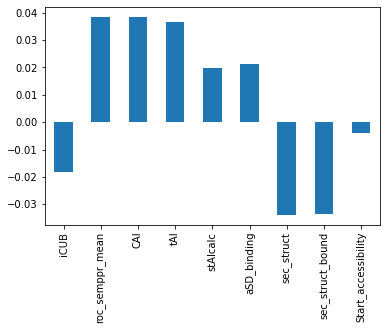

In [67]:
#Bar plot of average gene expression correlations
metrics_corr.loc[0].plot.bar(x='Metric', y='Spearman')

<AxesSubplot:>

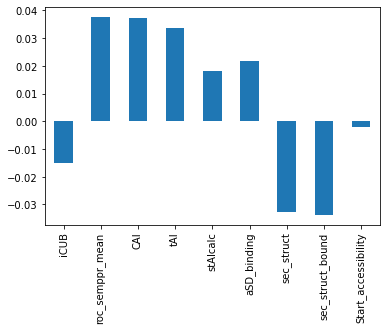

In [68]:
#Bar plot of median gene expression correlations
metrics_corr.loc[1].plot.bar(x='Metric', y='Spearman')

<AxesSubplot:>

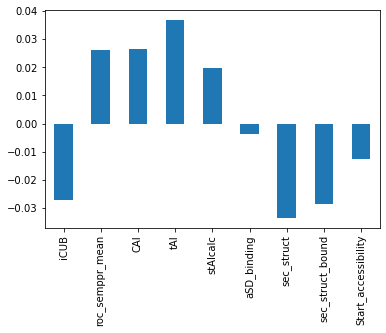

In [69]:
#Bar plot of max gene expression correlations
metrics_corr.loc[2].plot.bar(x='Metric', y='Spearman')

<AxesSubplot:>

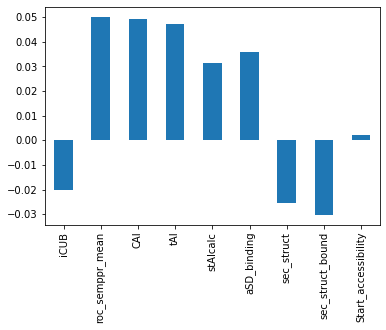

In [70]:
#Bar plot of min gene expression correlations
metrics_corr.loc[3].plot.bar(x='Metric', y='Spearman')